In [1]:
%matplotlib widget
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.spatial

import planeslam.io as io
import planeslam.general as general

import time

%load_ext autoreload
%autoreload 2

In [2]:
binpath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_60_samples_loop_closure', 'lidar', 'Drone0')
PCs = io.read_lidar_bin(binpath)
P = PCs[0]
(n,_) = P.shape

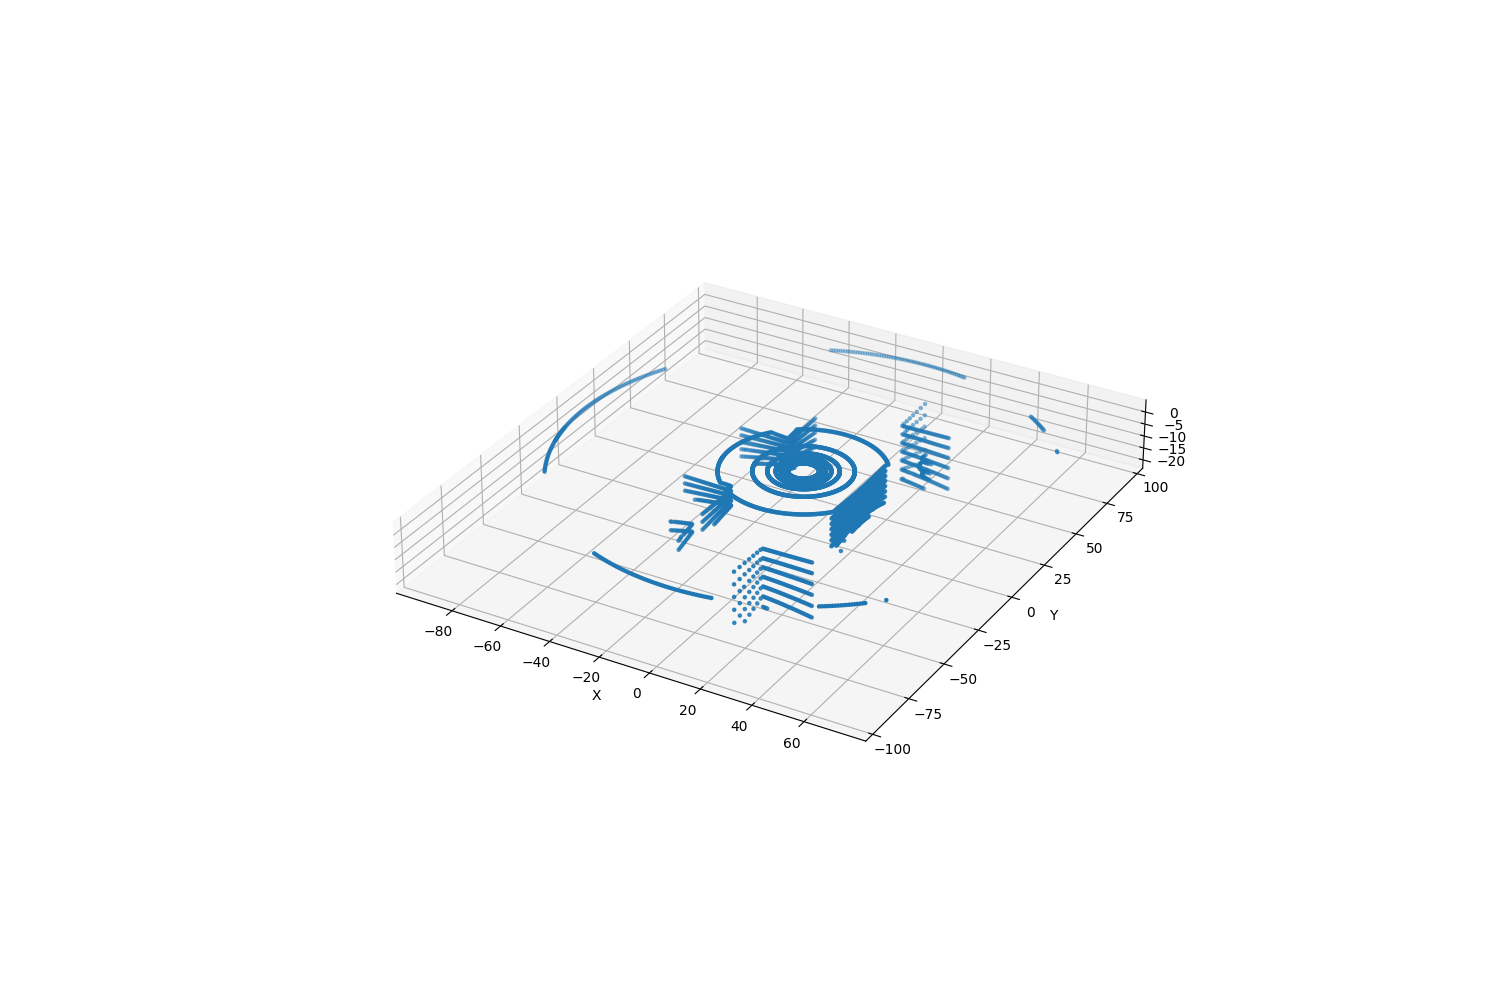

In [157]:
# Plot the points
ax = general.plot_3D_setup(P)
ax.scatter3D(P[:,0], P[:,1], P[:,2], marker='.')  

In [3]:
# Find all neighborhoods
neighbor_radius = 5.0
start = time.time()
kdtree = scipy.spatial.KDTree(P)
pairs = kdtree.query_pairs(neighbor_radius,output_type="ndarray")
#pairs.sort(axis=0)
print("Time taken to get neighbors:",time.time()-start)

Time taken to get neighbors: 0.06875300407409668


In [4]:
# Collect pairs
col = [[] for i in range(n)]
for (i,j) in pairs:
    col[i].append(j)
    col[j].append(i)

In [169]:
n

7030

In [5]:
# Estimate normals
num_ransac = 1
normals = np.zeros_like(P)
for i in range(n):
    if not col[i]:
        continue
    pts = P[col[i],:]
    best_nor = None
    best_fit = np.inf
    for _ in range(num_ransac):
        sub_idx = np.random.choice(range(pts.shape[0]),int(np.ceil(pts.shape[0]/2)),replace=False)
        pts_sub = pts[sub_idx,:]
        mn = pts_sub.mean(axis=0)
        cov = np.sum([np.outer(pts_sub[i,:]-mn,pts_sub[i,:]-mn) for i in range(pts_sub.shape[0])],axis=0)
        (_,S,V) = np.linalg.svd(cov)
        if S[-1] < best_fit:
            best_fit = S[-1]
            best_nor = V[-1,:]
    if P[i,:] @ best_nor > 0:
        best_nor *= -1
    normals[i] = best_nor
    

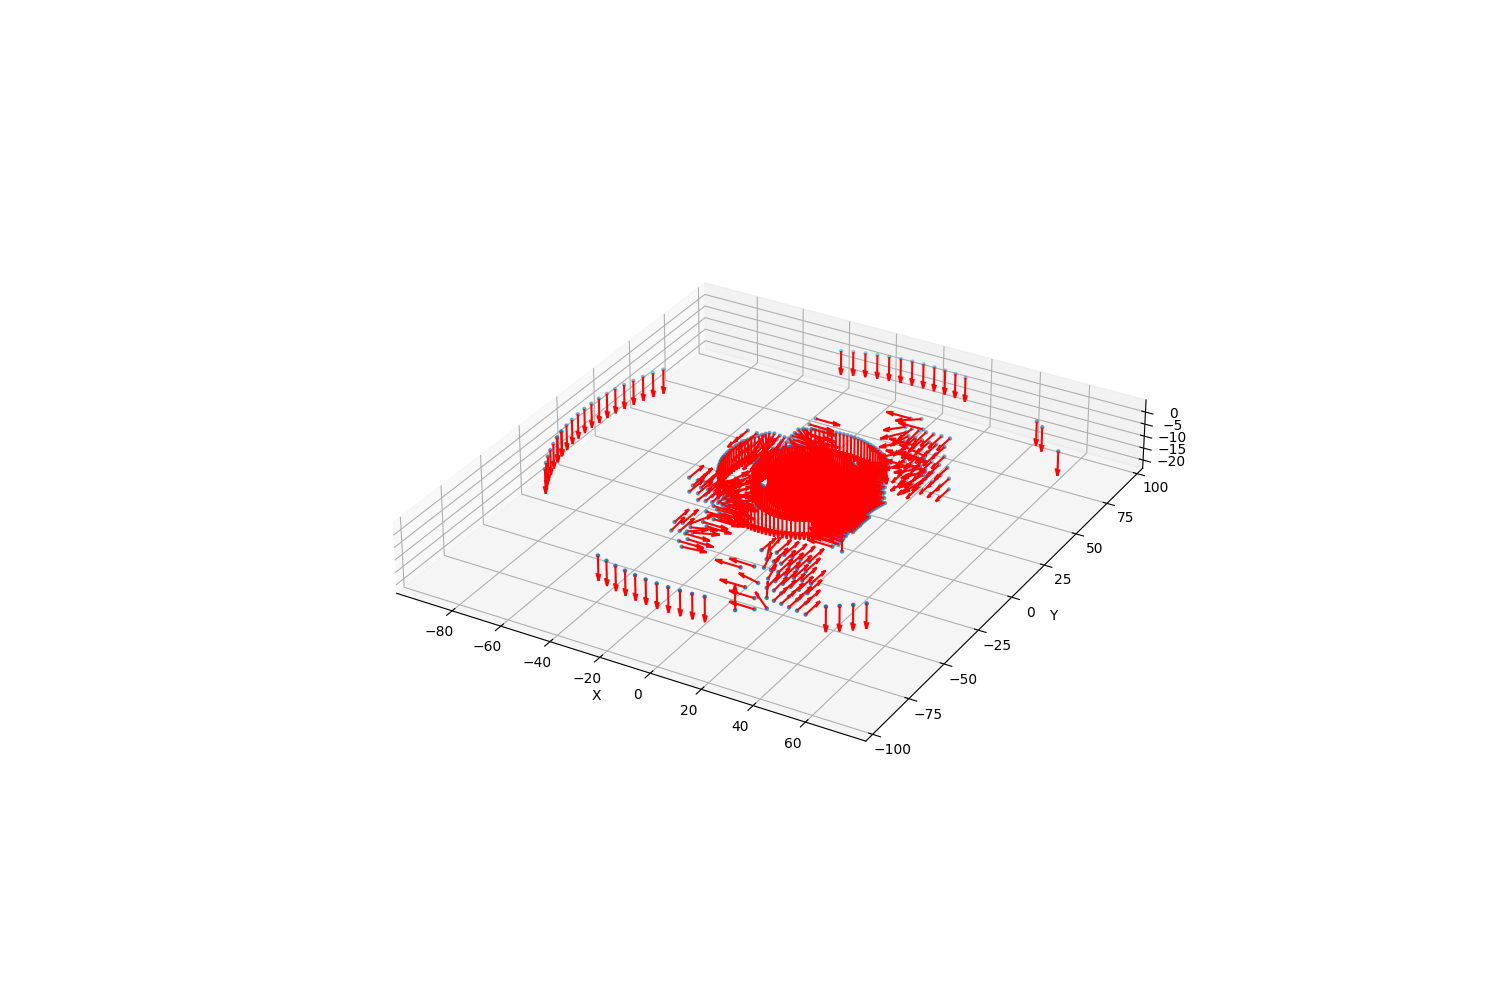

In [6]:
# Plot normals 
plt_P = general.downsample(P, factor=5, axis=0)
plt_normals = 10*general.downsample(normals, factor=5, axis=0)
ax = general.plot_3D_setup(P)
ax.scatter3D(plt_P[:,0], plt_P[:,1], plt_P[:,2], marker='.')  
ax.quiver(plt_P[:,0],plt_P[:,1],plt_P[:,2],plt_normals[:,0],plt_normals[:,1],plt_normals[:,2],color='r')